## 深度学习演示1：ImageNet 模型演示

这里演示一个ImageNet模型的效果，模型来自CCV项目。


1. 首先我们下载一个已经训练好的模型文件

wget -c http://static.libccv.org/image-net-2012-vgg-d.sqlite3

wget -c https://raw.githubusercontent.com/liuliu/ccv/stable/samples/image-net-2012.words 

2. 安装loadcvv

loadccv is tool which convert libccv model to Torch. This tool is coming from github (https://github.com/deltheil/loadccv).

3. 转换为Torch模型

```
loadccv ./image-net-2012-vgg-d.sqlite3
```

这样我们可以Torch下使用的模型文件`net.bin`以及`meta.bin`

### 1. 装载和初始化网络结构

首先我们来看一下VGG模型的结构：

```
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> (14) -> (15) -> (16) -> (17) -> (18) -> (19) -> (20) -> (21) -> (22) -> (23) -> (24) -> (25) -> (26) -> (27) -> (28) -> (29) -> (30) -> (31) -> (32) -> (33) -> (34) -> (35) -> (36) -> (37) -> (38) -> output]
  (1): nn.SpatialConvolutionMM(3 -> 64, 3x3, 1,1)
  (2): nn.ReLU
  (3): nn.SpatialConvolutionMM(64 -> 64, 3x3, 1,1)
  (4): nn.ReLU
  (5): nn.SpatialMaxPooling(3,3,2,2)
  (6): nn.SpatialConvolutionMM(64 -> 128, 3x3, 1,1)
  (7): nn.ReLU
  (8): nn.SpatialConvolutionMM(128 -> 128, 3x3, 1,1)
  (9): nn.ReLU
  (10): nn.SpatialMaxPooling(3,3,2,2)
  (11): nn.SpatialConvolutionMM(128 -> 256, 3x3, 1,1)
  (12): nn.ReLU
  (13): nn.SpatialConvolutionMM(256 -> 256, 3x3, 1,1)
  (14): nn.ReLU
  (15): nn.SpatialConvolutionMM(256 -> 256, 3x3, 1,1)
  (16): nn.ReLU
  (17): nn.SpatialMaxPooling(3,3,2,2)
  (18): nn.SpatialConvolutionMM(256 -> 512, 3x3, 1,1)
  (19): nn.ReLU
  (20): nn.SpatialConvolutionMM(512 -> 512, 3x3, 1,1)
  (21): nn.ReLU
  (22): nn.SpatialConvolutionMM(512 -> 512, 3x3, 1,1)
  (23): nn.ReLU
  (24): nn.SpatialMaxPooling(3,3,2,2)
  (25): nn.SpatialConvolutionMM(512 -> 512, 3x3, 1,1)
  (26): nn.ReLU
  (27): nn.SpatialConvolutionMM(512 -> 512, 3x3, 1,1)
  (28): nn.ReLU
  (29): nn.SpatialConvolutionMM(512 -> 512, 3x3, 1,1)
  (30): nn.ReLU
  (31): nn.SpatialMaxPooling(3,3,2,2)
  (32): nn.Transpose
  (33): nn.Reshape(18432)
  (34): nn.Linear(18432 -> 4096)
  (35): nn.ReLU
  (36): nn.Linear(4096 -> 4096)
  (37): nn.ReLU
  (38): nn.Linear(4096 -> 1000)
}
```


In [1]:
-- 首先载入Meta信息
require('nn')
meta = torch.load('./meta.bin')
print(meta)

-- 载入分类文本
local fc = io.open("image-net-2012.words")
local classText = {}
while true do
    local line = fc:read()
    if line == nil then break end
    table.insert(classText, line)
end
fc:close()

-- 列出分类文本信息
for i=500,510 do
    print('==>' .. classText[i])
end

meta.classText = classText

{
  input : 
    {
      width : 225
      channels : 3
      height : 225
    }
  package : nn
  mean : FloatTensor - size: 3x257x257
  num_output : 1000
  cuda : false
  lrn : nn
}


==>tree frog, tree-frog	
==>tailed frog, bell toad, ribbed toad, tailed toad, Ascaphus trui	
==>whistle	
==>wing	
==>paintbrush	
==>hand blower, blow dryer, blow drier, hair dryer, hair drier	
==>oxygen mask	
==>snorkel	
==>loudspeaker, speaker, speaker unit, loudspeaker system, speaker system	
==>microphone, mike	
==>screen, CRT screen	


In [2]:
-- 装载最后的Torch模型
model = torch.load('net.bin')

### 2. 装载测试数据

这里随机挑选了几张图片做测试，看看top5的输出。


In [3]:
require('image')

orignalImages = {}
for i=1,10 do
  local img = image.loadPNG('./images/'..i..'.png', 3)
  orignalImages[i] = img:float()
end

-- 进行数据的预处理
testImages = {}
local imageMean = meta.mean:sub(1, 3, 1,256, 1,256)


for i=1,#orignalImages do
  local img = orignalImages[i] * 256
  img = img - imageMean
  img = image.crop(img, 10, 10, 235, 235)
  testImages[i] = img
end


### 3. 检查测试结果

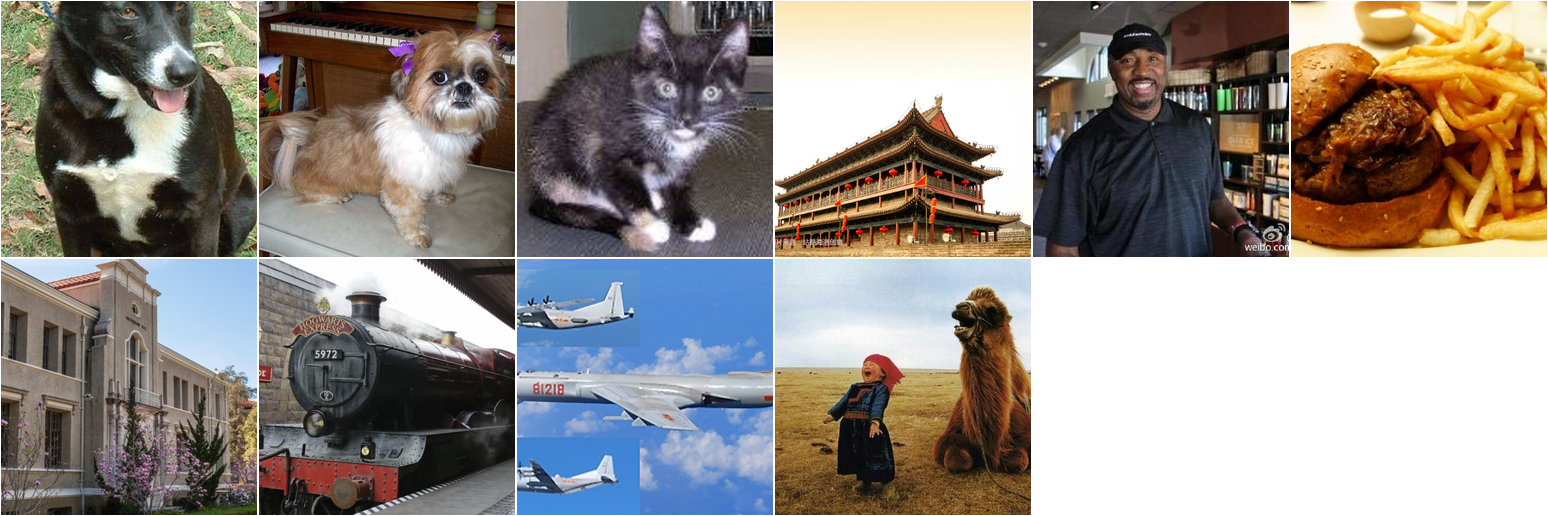

1------------------------	
1==> kelpie	
2==> Cardigan, Cardigan Welsh corgi	
3==> Border collie	
4==> basenji	
5==> Eskimo dog, husky	


2------------------------	
1==> Shih-Tzu	
2==> Lhasa, Lhasa apso	
3==> Pekinese, Pekingese, Peke	
4==> Japanese spaniel	
5==> Brabancon griffon	


3------------------------	
1==> Egyptian cat	
2==> Siamese cat, Siamese	
3==> tabby, tabby cat	
4==> lynx, catamount	
5==> tiger cat	


4------------------------	
1==> bell cote, bell cot	
2==> palace	
3==> monastery	
4==> gondola	
5==> analog clock	


5------------------------	
1==> tobacco shop, tobacconist shop, tobacconist	
2==> sweatshirt	


3==> barbershop	
4==> jersey, T-shirt, tee shirt	
5==> academic gown, academic robe, judge's robe	


6------------------------	
1==> cheeseburger	
2==> pretzel	
3==> carbonara	
4==> hen-of-the-woods, hen of the woods, Polyporus frondosus, Grifola frondosa	
5==> plate	


7------------------------	


1==> monastery	
2==> palace	
3==> bell cote, bell cot	
4==> library	
5==> church, church building	


8------------------------	
1==> steam locomotive	
2==> passenger car, coach, carriage	
3==> electric locomotive	
4==> freight car	
5==> tank, army tank, armored combat vehicle, armoured combat vehicle	


9------------------------	
1==> airliner	
2==> wing	
3==> warplane, military plane	
4==> missile	
5==> projectile, missile	


10------------------------	
1==> llama	
2==> Arabian camel, dromedary, Camelus dromedarius	
3==> baboon	
4==> Afghan hound, Afghan	
5==> macaque	
### 总用时:6.2827451229095	


In [4]:
itorch.image( orignalImages)


local tb = sys.clock()
for i=1, #testImages do
    local scores = model:forward(testImages[i])
    local _, results = torch.sort(scores, true)
    print(i .. "------------------------")
    for j = 1, 5 do
      print(j .. "==> " .. meta.classText[ results[j] ] )
    end
end
local totalTime = sys.clock() - tb

print("### 总用时:" .. totalTime)


### 4.切换到GPU进行计算


In [8]:
require('cunn')
require('cutorch')
model:cuda()

for i=1, #testImages do
  testImages[i] = testImages[i]:float():cuda()
end

local tb = sys.clock()
for i=1, #testImages do
    local scores = model:forward(testImages[i])
    scores:float()
    local _, results = torch.sort(scores, true)
    --print(i .. "------------------------")
    --for j = 1, 5 do
    --  print(j .. "==> " .. meta.classText[ results[j] ] )
    --end
end
local totalTime = sys.clock() - tb

print("### 总用时:" .. totalTime)

### 总用时:0.41707515716553	
